In [2]:
# import
import csv
import math
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM

from sklearn.cluster import KMeans

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)

%matplotlib inline

random.seed

<bound method Random.seed of <random.Random object at 0x102888e18>>

In [32]:
kernel = 1.4 * RationalQuadratic(length_scale=0.08, alpha=2.1) + 1.0*ExpSineSquared(length_scale = 50, periodicity=1)
# for floor in range(0,5):
#     for building in range(0,3):
for floor in range(2,3):
    for building in range(0,1):
        
        ## Count the number of data points in building id & floor id
        data_num = 0
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num += 1
        print(data_num)
        ## if there are no data, continue to next floor 
        if (data_num == 0):
            continue
            
        ## Load data points in
        wifi_loc_time = np.zeros(shape = (data_num, 524))
        i=-1
        with open("1478167720_9233432_trainingData.csv", newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',')
            for row in spamreader:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i = i+1
                if (i > data_num):
                    break
                # wifi
                wifi_loc_time[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time[i-1][-1] = np.array(row[-1])
        
        ## Sort by time stamp
        wifi_loc_time = wifi_loc_time[wifi_loc_time[:,-1].argsort()]
        
        ## List all users
        user_list = np.unique(wifi_loc_time[:, 522])
        user_num = len(user_list)
        print("On floor ", floor, " in building ", building, "there are ", user_num, " users.")
        
        ## Make grids
        grid_slice = 20
        grids = 2
        kmeans = KMeans(n_clusters = grids, random_state=0).fit(wifi_loc_time[:, 520:522])
        centers = kmeans.cluster_centers_
        dx = centers[0,0] - centers[1,0]
        dy = centers[0,1] - centers[1,1]
        R = math.sqrt(pow(centers[0,0] - centers[1,0], 2) + pow(centers[0,1] - centers[1,1], 2))
        cos = dx / R
        sin = - dy / R
        rotate = np.array([[cos, -sin],[sin, cos]])
        
        coordinates = np.zeros(shape=(len(wifi_loc_time[:,522]),2))
        
        for i in range(len(wifi_loc_time[:,522])):
            coordinates[i] = np.matmul(rotate, wifi_loc_time[i,520:522])
        
        
                                    ## max boundary , grid size, min boundary
        longitude_list = np.array([max(coordinates[:,0]), (max(coordinates[:,0])-min(coordinates[:,0]))/grid_slice\
                                   , min(coordinates[:,0])])
        latitude_list = np.array([max(coordinates[:,1]), (max(coordinates[:,1])-min(coordinates[:,1]))/grid_slice\
                                   , min(coordinates[:,1])])
        
        ## state tag = [grid_slice x grid_slice]
        state_tag = np.zeros(shape=(grid_slice, grid_slice), dtype=int)
        ## initialize to -1
        for i in range(grid_slice):
            for j in range(grid_slice):
                state_tag[i][j] = -1
        
        ## Record each user's number of location logs
        user_walking_num = np.zeros(shape=(user_num), dtype=int)
        for i in range(len(wifi_loc_time[:,522])):
            for user_index in range(user_num):
                if (wifi_loc_time[i, 522] == user_list[user_index]):
                    user_walking_num[user_index] += 1
        
        ## set the sequence length of observed walking tracks
        seq_window = 9
        total_batch_num = 0
        
        ## compute all users' walking sequences and add them as number of batches
        for num in user_walking_num:
            total_batch_num += math.floor(num/seq_window)
        print("total_batch_num: ",total_batch_num)
        
        batch_wifi = np.zeros((total_batch_num, seq_window, 520))
        batch_loc = np.zeros((total_batch_num, seq_window), dtype = int)
        
        ## tracking parameters
        state_count = 0
        ## cumulative graduation [# of batch of user1] + [# of batch of user2] [...]
        batch_num = 0
        iter_batch = 0
        iter_window = 0
        state_map_grid = {}
        
        for k in range(len(user_list)):
            print("User",k, " walking ", user_walking_num[k])
            
            ## [longitude, latitude, wifi]
            user_fp = np.zeros((user_walking_num[k], 2+520))
            batch_num += math.floor(user_walking_num[k]/seq_window)
            
            ## pick out the corresponding user's data
            user_i = 0
            for i in range(len(wifi_loc_time[:,522])):
                if (wifi_loc_time[i, 522] == user_list[k]):
                    user_fp[user_i, :2] = np.array(coordinates[i])
                    user_fp[user_i, 2:] = np.array(wifi_loc_time[i, :520])
                    user_i += 1
        
            for s in range(math.floor(user_walking_num[k]/seq_window) * seq_window):
                ## put state id
                i = int(math.ceil((user_fp[s][0] - longitude_list[2])/longitude_list[1]) - 1)
                j = int(math.ceil((user_fp[s][1] - latitude_list[2])/latitude_list[1]) - 1)
                if (i == -1):
                    i = 0
                elif (i >= grid_slice): 
                    i = grid_slice-1
                if (j == -1):
                    j = 0
                elif (j >= grid_slice): 
                    j = grid_slice-1
                if (state_tag[i][j] == -1):
                    ## apply GPs
                    gp = GaussianProcessRegressor(kernel=kernel,
                                          alpha=0.5)
                    grid_wifi_data = user_fp[s][2:].copy()
                    grid_loc_data = np.array([user_fp[s][0] - (longitude_list[1]*(float(i)+0.5) + longitude_list[2])\
                                              , user_fp[s][1] - (latitude_list[1]*(float(j)+0.5) + latitude_list[2])])
                    
                    state_tag[i][j] = state_count
                    state_map_grid[state_count] = [i,j, gp, grid_wifi_data, grid_loc_data]
                    state_count += 1
                else:
                    state_map_grid[state_tag[i][j]][3] = np.vstack((state_map_grid[state_tag[i][j]][3], user_fp[s][2:].copy()))
                    state_map_grid[state_tag[i][j]][4] = np.vstack((state_map_grid[state_tag[i][j]][4], \
                               np.array([user_fp[s][0] - (longitude_list[1]*(float(i)+0.5) + longitude_list[2])\
                                        , user_fp[s][1] - (latitude_list[1]*(float(j)+0.5) + latitude_list[2])])))
                    
                batch_wifi[iter_batch][iter_window] = user_fp[s][2:].copy()
                batch_loc[iter_batch,iter_window] = state_tag[i][j]

                
                if (iter_window == (seq_window-1)):
                    iter_window = 0
                    iter_batch = iter_batch + 1
                    if (iter_batch == (batch_num)):
                        break
                else:
                    iter_window = iter_window + 1
        print("Grid is ", grid_slice, "x", grid_slice, " ; the # of states is ", state_count)
        for s in range(state_count):
            print("State ", s, "; data points: ", state_map_grid[s][4].shape)
            state_map_grid[s][2] = state_map_grid[s][2].fit(state_map_grid[s][3], state_map_grid[s][4])
                    
        # Testing
        # extract data
        print("Validation...")
        data_num_v = 0
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                data_num_v += 1

        print(data_num_v)
        if (data_num_v == 0):
            continue
        i = -1
        wifi_loc_time_v = np.zeros(shape = (data_num_v, 524))
        
        with open("1478167721_0345678_validationData.csv", newline='') as v_csvfile:
            spamreader_v = csv.reader(v_csvfile, delimiter=',')
            for row in spamreader_v:
                if (row[523] == 'BUILDINGID'):
                    continue
                elif (int(row[523]) is not building or int(row[522]) is not floor):
                    continue
                i += 1
                #if (i > data_num):
                #    break
                # wifi
                wifi_loc_time_v[i-1][:520] = np.array(row[:520])
                # location x, y
                wifi_loc_time_v[i-1][520:522] = np.array(row[520:522])
                # userID
                wifi_loc_time_v[i-1][522] = np.array(row[526])
                # time stamp
                wifi_loc_time_v[i-1][-1] = np.array(row[-1])
                
        wifi_loc_time_v = wifi_loc_time_v[wifi_loc_time_v[:,-1].argsort()]  
                
        batch_num = int(data_num_v/seq_window)
        print("Validating data ", batch_num)
        batch_wifi_v = np.zeros((batch_num + 1, seq_window, 520))
        batch_loc_v = np.zeros((batch_num + 1, seq_window), dtype = int)

        iter_window = 0
        iter_batch = 1
        
        map_distance = 0
        adjust_grid_num = 0
                               
        coordinates_v = np.zeros(shape=(len(wifi_loc_time_v[:,522]),2))
        
        for i in range(len(wifi_loc_time_v[:,522])):
            coordinates_v[i] = np.matmul(rotate, wifi_loc_time_v[i,520:522])

        for s in range(len(wifi_loc_time_v)):
            
            i = int(math.ceil((coordinates_v[s][0]-longitude_list[2])/longitude_list[1]) - 1)
            j = int(math.ceil((coordinates_v[s][1]-latitude_list[2])/latitude_list[1]) - 1)
            if (i < -1):
                i = 0
            elif (i >= grid_slice): 
                i = grid_slice-1
            if (j < 0):
                j = 0
            elif (j >= grid_slice): 
                j = grid_slice-1
            if (state_tag[i][j] == -1):
                adjust_grid_num+=1
                min_dist = np.zeros(shape=(state_count, 1))
                for x in range(state_count):
                    min_dist[x,0] = math.sqrt(pow((float(state_map_grid[x][0])+0.5)*longitude_list[1]+longitude_list[2] - coordinates_v[s][0],2)+\
                              pow((float(state_map_grid[x][1])+0.5)*latitude_list[1]+latitude_list[2] - coordinates_v[s][1],2))
                map_distance += np.min(min_dist)
                state_tag[i][j] = np.argmin(min_dist)
            
            batch_wifi_v[iter_batch][iter_window] = wifi_loc_time_v[s][:520]
            batch_loc_v[iter_batch,iter_window] = state_tag[i][j]
            if (iter_window == (seq_window-1)):
                iter_window = 0
                iter_batch = iter_batch + 1
                if (iter_batch == (batch_num)):
                    break
            else:
                iter_window = iter_window + 1  
        print("Grids need adjustment: ", adjust_grid_num)
        print("Base map distance is ", map_distance/data_num_v)
                
        model = ChainCRF()
        ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=80)            
        ssvm.fit(batch_wifi, batch_loc)
        
        pred_batch_v = ssvm.predict(batch_wifi_v)
        total_error = 0

        center_longitude_pred = 0
        center_latitude_pred = 0
        center_longitude_gt = 0
        center_latitude_gt = 0
        
        real_longitude = 0
        real_latitude = 0

        iter_test = 0
        
        window = np.zeros((seq_window))
        
        gp_total_error = 0
        gp_window = np.zeros((seq_window))
        
        rotate_space_error = 0
        
        error_list = []
                                 
        inverse = np.linalg.inv(rotate)
        
        for i in range(1,batch_num+1):
            for j in range(seq_window):
                ans = state_map_grid[pred_batch_v[i][j]][2].predict(batch_wifi_v[i][j].reshape(1,520))
                
                center_longitude_pred = (float(state_map_grid[pred_batch_v[i][j]][0])+0.5)*longitude_list[1]
                center_latitude_pred = (float(state_map_grid[pred_batch_v[i][j]][1])+0.5)*latitude_list[1]
                center_longitude_gt = (float(state_map_grid[batch_loc_v[i][j]][0])+0.5)*longitude_list[1]
                center_latitude_gt = (float(state_map_grid[batch_loc_v[i][j]][1])+0.5)*latitude_list[1]
                
                print("\nGrid box: ", i, j)
                print("Predict grid ", pred_batch_v[i][j], "; Gt grid ", batch_loc_v[i][j])
                print("longitude ", center_longitude_pred, center_longitude_gt)
                print("latitude ", center_latitude_pred, center_latitude_gt)
                
                print(ans[0][0], ans[0][1])
                print("Add...")
                ans[0][0] += center_longitude_pred + longitude_list[2]
                ans[0][1] += center_latitude_pred + latitude_list[2]
                
                rotate_gt = np.matmul(rotate, np.array([wifi_loc_time_v[iter_test][520], wifi_loc_time_v[iter_test][521]]))
                rotate_space_error += math.sqrt(pow(ans[0][0] - rotate_gt[0],2)+pow(ans[0][1] - rotate_gt[1],2))
                
                ans = np.matmul(inverse, np.array([ans[0][0], ans[0][1]]))
                real_longitude = wifi_loc_time_v[iter_test][520]
                real_latitude = wifi_loc_time_v[iter_test][521]
                
                
                
                print("predict: ", ans[0], ans[1])
                print("real: ", real_longitude, real_latitude)
                print("Percent:")
                print(ans[0]-real_longitude, (ans[0]-real_longitude)/longitude_list[1], ans[1] - real_latitude, (ans[1]-real_latitude)/latitude_list[1])
                print("RMSE: ", math.sqrt(pow(ans[0] - real_longitude,2)+pow(ans[1] - real_latitude,2)))
                
                error_list.append(math.sqrt(pow(ans[0] - real_longitude,2)+pow(ans[1] - real_latitude,2)))
                
                gp_total_error += math.sqrt(pow(ans[0] - real_longitude,2)+pow(ans[1] - real_latitude,2))
                gp_window[j] += math.sqrt(pow(ans[0] - real_longitude,2)+pow(ans[1] - real_latitude,2))
                
                iter_test+=1
                
                total_error += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                            
                window[j] += math.sqrt(pow(center_longitude_pred - center_longitude_gt,2)+pow(center_latitude_pred - center_latitude_gt,2))
                

        print("\nbox\nRMSE: ", total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, window[x]/batch_num)
        print("gp")
        print("RMSE: ", gp_total_error/(batch_num*seq_window))
        print("Windows:")
        for x in range(seq_window):
            print(" ", x, gp_window[x]/batch_num)
        print("Rotate_space RMSE: ", rotate_space_error)
        print("Finish\n")

1443
On floor  2  in building  0 there are  2  users.
total_batch_num:  159
User 0  walking  733
User 1  walking  710
Grid is  20 x 20  ; the # of states is  48
State  0 ; data points:  (20, 2)
State  1 ; data points:  (20, 2)
State  2 ; data points:  (19, 2)
State  3 ; data points:  (20, 2)
State  4 ; data points:  (60, 2)
State  5 ; data points:  (58, 2)
State  6 ; data points:  (39, 2)
State  7 ; data points:  (20, 2)
State  8 ; data points:  (20, 2)
State  9 ; data points:  (19, 2)
State  10 ; data points:  (20, 2)
State  11 ; data points:  (49, 2)
State  12 ; data points:  (60, 2)
State  13 ; data points:  (67, 2)
State  14 ; data points:  (40, 2)
State  15 ; data points:  (20, 2)
State  16 ; data points:  (12, 2)
State  17 ; data points:  (19, 2)
State  18 ; data points:  (20, 2)
State  19 ; data points:  (25, 2)
State  20 ; data points:  (20, 2)
State  21 ; data points:  (30, 2)
State  22 ; data points:  (19, 2)
State  23 ; data points:  (29, 2)
State  24 ; data points:  (40, 2)


Grid box:  3 5
Predict grid  1 ; Gt grid  8
longitude  78.61728169948329 83.68936438977254
latitude  43.05712472103769 39.8677080750349
-0.3184321437124786 -0.4729742295952848
Add...
predict:  -7643.391078670276 4864927.877277497
real:  -7652.152865217898 4864925.906269594
Percent:
8.761786547621341 1.7274534116717417 1.9710079031065106 0.6179838264708126
RMSE:  8.980744716346559

Grid box:  3 6
Predict grid  8 ; Gt grid  0
longitude  83.68936438977254 78.61728169948329
latitude  39.8677080750349 39.8677080750349
-2.0196345166293073 0.671674803260539
Add...
predict:  -7646.822563223075 4864925.935931967
real:  -7644.278508366051 4864929.1271200245
Percent:
-2.5440548570240935 -0.501579925322356 -3.191188057884574 -1.0005554030966768
RMSE:  4.081163600780175

Grid box:  3 7
Predict grid  1 ; Gt grid  0
longitude  78.61728169948329 78.61728169948329
latitude  43.05712472103769 39.8677080750349
-0.3184543787875249 -0.4730072558387018
Add...
predict:  -7643.391096614301 4864927.877313037



Grid box:  6 3
Predict grid  35 ; Gt grid  36
longitude  12.68020672572311 7.608124035433867
latitude  11.162958261009772 4.784124969004187
9.589323855474177e-05 2.4829607102611126e-05
Add...
predict:  -7638.730246357853 4865000.481410334
real:  -7641.380978970188 4865006.834357185
Percent:
2.6507326123355597 0.5226122628896646 -6.352946851402521 -1.9918836441029097
RMSE:  6.883772009505001

Grid box:  6 4
Predict grid  37 ; Gt grid  36
longitude  2.536041345144622 7.608124035433867
latitude  1.5947083230013959 4.784124969004187
-1.3742646297053436 -0.7864273561394901
Add...
predict:  -7642.133768373635 4865015.591418042
real:  -7641.76361680523 4865008.641523564
Percent:
-0.37015156840425334 -0.07297822038921546 6.94989447761327 2.179048788223822
RMSE:  6.959744638530322

Grid box:  6 5
Predict grid  42 ; Gt grid  31
longitude  27.896454796590845 22.8243721063016
latitude  30.299458137026523 23.92062484502094
0.07044248377482294 1.5453649405914698
Add...
predict:  -7628.158995340113 


Grid box:  9 8
Predict grid  14 ; Gt grid  14
longitude  98.90561246064027 98.90561246064027
latitude  1.5947083230013959 1.5947083230013959
2.0209923161629506 -0.5077622964472237
Add...
predict:  -7690.653528940398 4864928.419568189
real:  -7689.269485301836 4864933.682809857
Percent:
-1.3840436385626163 -0.2728748175207074 -5.263241667300463 -1.6502207931650257
RMSE:  5.44217692121943

Grid box:  10 0
Predict grid  37 ; Gt grid  37
longitude  2.536041345144622 2.536041345144622
latitude  1.5947083230013959 1.5947083230013959
-1.3801613735971996 -0.7924971711816595
Add...
predict:  -7642.1361815293785 4865015.599529203
real:  -7641.35243999958 4865015.713279997
Percent:
-0.7837415297981352 -0.1545206530837219 -0.11375079397112131 -0.035665078162077715
RMSE:  0.7919532995444755

Grid box:  10 1
Predict grid  24 ; Gt grid  25
longitude  17.752289416012356 12.68020672572311
latitude  46.24654136704048 52.62537465904607
0.4844947513146318 0.9776476883332369
Add...
predict:  -7609.9860449


Grid box:  13 5
Predict grid  4 ; Gt grid  6
longitude  88.76144708006177 98.90561246064027
latitude  52.62537465904607 62.19362459705444
0.03355992894158899 -0.09704526680445563
Add...
predict:  -7639.845989059657 4864913.859847099
real:  -7631.1041887757965 4864902.250530308
Percent:
-8.741800283860357 -1.723512966497366 11.609316790476441 3.6399498964884627
RMSE:  14.53256028869446

Grid box:  13 6
Predict grid  24 ; Gt grid  23
longitude  17.752289416012356 22.8243721063016
latitude  46.24654136704048 43.05712472103769
0.530300543012471 0.9207258239729331
Add...
predict:  -7610.058092905907 4864977.995821318
real:  -7615.037843382428 4864975.903921388
Percent:
4.979750476521076 0.9817959959633658 2.0918999295681715 0.6558879449600579
RMSE:  5.401292449380908

Grid box:  13 7
Predict grid  26 ; Gt grid  27
longitude  7.608124035433867 7.608124035433867
latitude  55.81479130504886 59.00420795105165
-0.015412449404820783 0.9697757645272074
Add...
predict:  -7596.4429033536 4864982.62


Grid box:  17 2
Predict grid  34 ; Gt grid  34
longitude  17.752289416012356 17.752289416012356
latitude  14.352374907012562 14.352374907012562
0.23687990074920004 1.5340865064488405
Add...
predict:  -7637.20430374844 4864993.541178908
real:  -7637.181377864727 4864993.980789106
Percent:
-0.02292588371255988 -0.004520013791662472 -0.43961019814014435 -0.13783404519791911
RMSE:  0.44020759018083594

Grid box:  17 3
Predict grid  39 ; Gt grid  35
longitude  27.896454796590845 12.68020672572311
latitude  27.11004149102373 11.162958261009772
-2.176830977484948 -1.1029557205765315
Add...
predict:  -7632.153466460761 4864981.850327491
real:  -7637.55456227177 4865000.977893456
Percent:
5.401095811009327 1.0648674599390886 -19.12756596505642 -5.997198888714798
RMSE:  19.875502904512558

Grid box:  17 4
Predict grid  31 ; Gt grid  36
longitude  22.8243721063016 7.608124035433867
latitude  23.92062484502094 4.784124969004187
2.0512004963082493 -1.0292965740840765
Add...
predict:  -7634.4591247

(array([ 12.,  26.,  35.,  37.,  43.,  46.,  48.,  48.,  49.,  49.,  52.,
         59.,  61.,  65.,  72.,  78.,  79.,  85.,  92.,  93.,  97., 101.,
        102., 102., 104., 105., 106., 109., 113., 116., 120., 123., 126.,
        127., 129., 131., 134., 134., 134., 134., 136., 137., 141., 142.,
        142., 144., 144., 144., 144., 145., 146., 147., 148., 149., 151.,
        151., 151., 152., 152., 153., 153., 153., 154., 155., 156., 157.,
        157., 157., 157., 158., 158., 158., 158., 158., 158., 158., 159.,
        159., 159., 159., 159., 159., 159., 159., 159., 159., 160., 160.,
        160., 160., 160., 160., 160., 160., 160., 160., 160., 160., 160.,
        162.]),
 array([ 0.28940711,  0.75243976,  1.21547241,  1.67850506,  2.14153771,
         2.60457036,  3.06760301,  3.53063566,  3.99366831,  4.45670096,
         4.91973361,  5.38276626,  5.84579891,  6.30883156,  6.7718642 ,
         7.23489685,  7.6979295 ,  8.16096215,  8.6239948 ,  9.08702745,
         9.5500601 , 10.01

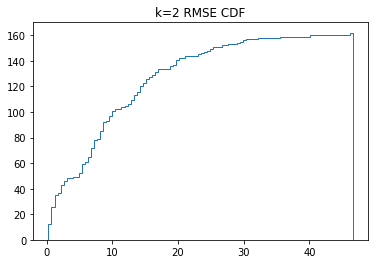

In [34]:
n_bins = 100
plt.title("k=2 RMSE CDF")
plt.hist(error_list, bins=n_bins, cumulative=True, histtype='step')

In [26]:
print(longitude_list)

[-4.24044344e+06  5.07208269e+00 -4.24054488e+06]


In [27]:
coordinates[0]

array([-4240455.68457169, -2384544.01081866])

In [28]:
wifi_loc_time[0][520:522]

array([  -7653.34330145, 4864920.96325149])

In [29]:
kmeans.cluster_centers_

array([[  -7656.8858547 , 4864926.48200535],
       [  -7622.42638037, 4864987.98787121]])

In [23]:
rotate

array([[-0.48877817, -0.8724081 ],
       [ 0.8724081 , -0.48877817]])